# Phase 2 — Statistical Modeling (Himalayan Expeditions)

**Project:** Himalayan Expeditions Research  
**Dataset:** Himalayan Expeditions Dataset (Educational / Synthetic)  
**Phase:** Statistical Modeling (Survival Analysis)

---

## Objective

The objective of this phase is to **quantify expedition risk dynamics using formal statistical survival analysis methods**.

Building on the cleaned and documented dataset from Phase 1, this phase focuses on modeling **time-to-event behavior**, accounting explicitly for **censoring, imbalance, and heterogeneity across expedition characteristics**. The primary goal is to understand how expedition risk evolves over time and how it differs across key covariates such as season, nationality, and route type.

This phase introduces **inferential modeling**, including nonparametric and semi-parametric survival techniques. Results are interpreted in terms of **hazard rates and relative risk**, without invoking predictive machine learning or complex nonlinear models, which are deferred to later phases.

In [5]:
# Imports
# Core data handling
import pandas as pd
import numpy as np

# Survival analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Continuity and Scope

This phase uses the **cleaned and documented dataset produced in Phase 1**.
No additional data sources are introduced.

All preprocessing steps—including variable cleaning, type conversion,
and handling of missing values—are inherited directly from the Phase 1
pipeline to ensure consistency and reproducibility.

The focus of this phase is **statistical modeling**, not further data
engineering.

In [6]:
# Load cleaned dataset produced in Phase 1
data_path = "../data/processed/himalayan_expeditions_clean.csv"
df = pd.read_csv(data_path, low_memory=False)

# Basic sanity check
df.shape, df.head()

((11425, 65),
        expid peakid  year  season   host            route1            route2  \
 0  ANN260101   ANN2  1960  Spring  Nepal  NW Ridge-W Ridge               NaN   
 1  ANN269301   ANN2  1969  Autumn  Nepal  NW Ridge-W Ridge               NaN   
 2  ANN273101   ANN2  1973  Spring  Nepal    W Ridge-N Face               NaN   
 3  ANN278301   ANN2  1978  Autumn  Nepal    N Face-W Ridge               NaN   
 4  ANN279301   ANN2  1979  Autumn  Nepal    N Face-W Ridge  NW Ridge of A-IV   
 
   route3 route4      nation  ...                           accidents  \
 0    NaN    NaN          UK  ...                                 NaN   
 1    NaN    NaN  Yugoslavia  ...  Draslar frostbitten hands and feet   
 2    NaN    NaN       Japan  ...                                 NaN   
 3    NaN    NaN          UK  ...                                 NaN   
 4    NaN    NaN          UK  ...                                 NaN   
 
   achievment  agency  comrte  stdrte  primrte primmem pri

The cleaned dataset from Phase 1 is successfully loaded, preserving the full
set of 11,425 expedition records and 65 variables for downstream survival
analysis.

---

## Event Definition and Censoring Structure

This phase models expedition risk using a **time-to-event framework**.
Survival analysis is appropriate given the presence of **right-censoring** and
heterogeneous expedition durations across Himalayan expeditions.

### Event Definition

An **event** is defined at the **expedition level** as the failure to achieve
a successful summit ascent.

Specifically, an expedition is considered **successful** if **at least one
summit ascent is recorded** across all documented ascent attempts. An expedition
is considered a **failure** if **no successful summit ascent is recorded**.

This definition reflects expedition-level risk, where exposure to failure
persists until either a summit is reached or the expedition is terminated.

Successful summit expeditions are treated as **right-censored observations**,
as the event of interest (failure) does not occur within the observed duration.

### Time Scale

The time-to-event variable is defined as the **total duration of the expedition
(in days)**. The variable `totdays` is used, representing the number of days
from expedition start until expedition termination or completion.

This choice captures the full exposure period during which expedition risk
accumulates.

### Censoring Logic

- **Event observed (`event = 1`)**: expedition records **no successful summit
  ascent**  
- **Right-censored (`event = 0`)**: expedition records **at least one successful
  summit ascent**

This censoring structure assumes that expeditions remain at risk throughout
their duration, with successful summit completion terminating exposure to
failure risk within the observation window.

In [7]:
# Expedition-level success:
# success if any recorded successful ascent
success_cols = ["success1", "success2", "success3", "success4"]

df["success"] = df[success_cols].any(axis=1)

In [8]:
# Time-to-event variable
df["duration"] = df["totdays"]

# Event definition:
# event = 1 → expedition failure (no summit)
# event = 0 → expedition success (right-censored)
df["event_observed"] = (~df["success"]).astype(int)

In [9]:
survival_df = df.dropna(subset=["duration", "event_observed"]).copy()

survival_df[["duration", "event_observed"]].describe()

,duration,event_observed
count,8406.000000,8406.000000
mean,26.337378,0.447656
std,15.506469,0.497282
min,0.000000,0.000000
25%,14.000000,0.000000
50%,24.000000,0.000000
75%,37.000000,1.000000
max,280.000000,1.000000


### Summary of Survival Variables

After constructing the time-to-event and censoring indicators, a total of
**8,406 expeditions** remain available for survival analysis after excluding
records with missing duration information.

The **expedition duration** has a mean of approximately **26 days**, with a
median duration of **24 days**, indicating moderate right-skewness. Most
expeditions last between **14 and 37 days**, while a small number of unusually
long expeditions extend up to **280 days**, reflecting heterogeneous expedition
strategies and logistical complexity.

The **event indicator** (`event_observed`) has a mean value of **0.45**, implying
that approximately **45% of expeditions experience failure** (no successful
summit), while the remaining **55% are right-censored** due to successful summit
completion. This level of censoring is substantial but well within the range
where Kaplan–Meier and Cox proportional hazards models remain appropriate.

Overall, the distribution of durations and the balance between observed events
and censored observations confirm that the dataset is suitable for formal
survival analysis, with sufficient variation in both time-to-event and outcome
status to support stratified estimation and regression-based hazard modeling.

---

## Kaplan–Meier Survival Estimates

Kaplan–Meier estimators are used to obtain **non-parametric survival functions**
for Himalayan expeditions. This approach allows visualization of expedition
survival probabilities over time **without imposing distributional assumptions**
on the underlying hazard process.

Survival curves are first estimated for the full sample and subsequently
stratified by key expedition characteristics to explore heterogeneity in risk
profiles across seasons, national contexts, and route types.

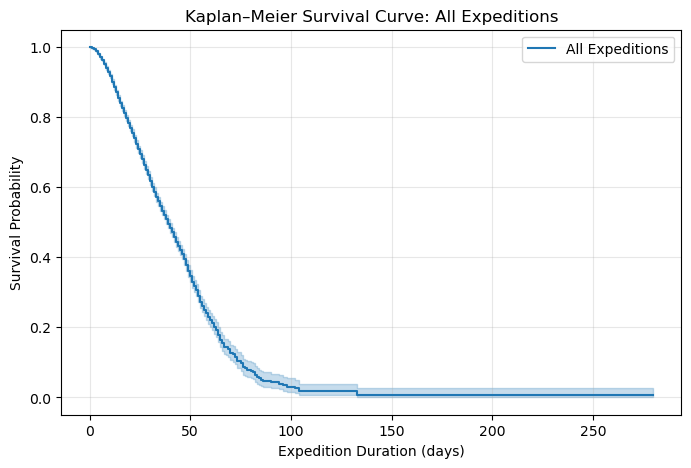

In [10]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))
kmf.fit(
    durations=survival_df["duration"],
    event_observed=survival_df["event_observed"],
    label="All Expeditions"
)
kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curve: All Expeditions")
plt.xlabel("Expedition Duration (days)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()

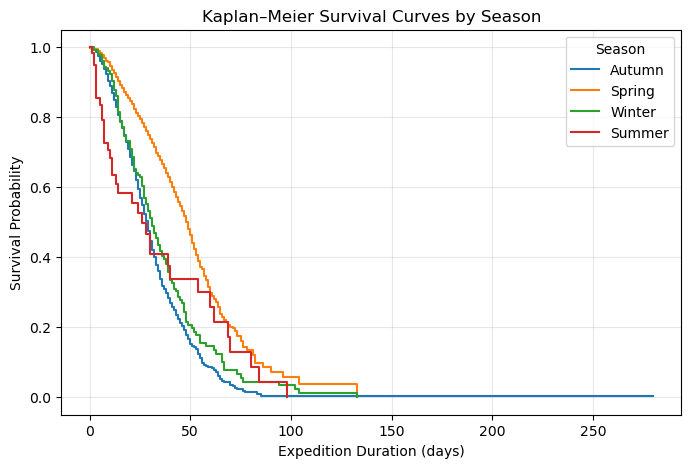

In [11]:
plt.figure(figsize=(8, 5))

for season in survival_df["season"].dropna().unique():
    ix = survival_df["season"] == season
    kmf.fit(
        durations=survival_df.loc[ix, "duration"],
        event_observed=survival_df.loc[ix, "event_observed"],
        label=season
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Season")
plt.xlabel("Expedition Duration (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Season")
plt.grid(alpha=0.3)
plt.show()

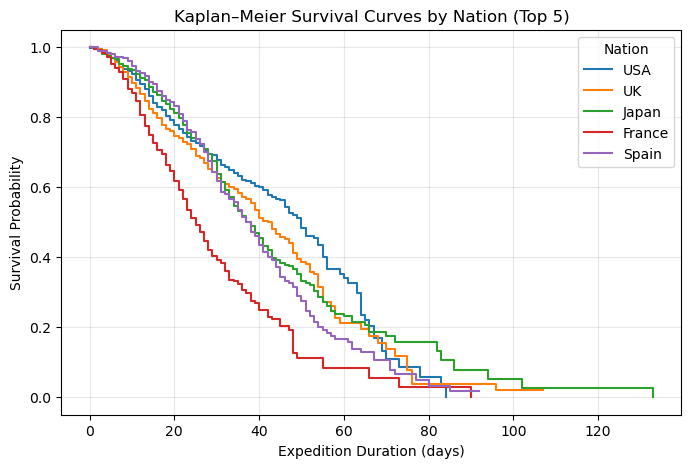

In [12]:
# Select top N nations by expedition count
top_n = 5
top_nations = (
    survival_df["nation"]
    .value_counts()
    .nlargest(top_n)
    .index
)

plt.figure(figsize=(8, 5))

for nation in top_nations:
    ix = survival_df["nation"] == nation
    kmf.fit(
        durations=survival_df.loc[ix, "duration"],
        event_observed=survival_df.loc[ix, "event_observed"],
        label=nation
    )
    kmf.plot_survival_function(ci_show=False)

plt.title(f"Kaplan–Meier Survival Curves by Nation (Top {top_n})")
plt.xlabel("Expedition Duration (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Nation")
plt.grid(alpha=0.3)
plt.show()

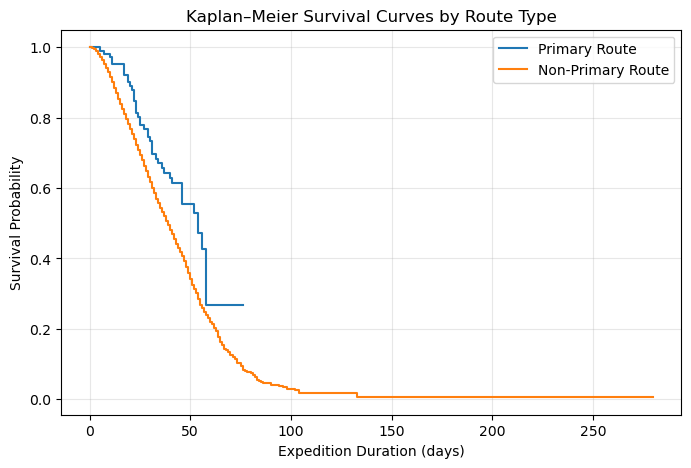

In [13]:
# Define route type: primary route vs others
survival_df["primary_route"] = survival_df["primrte"].astype(bool)

plt.figure(figsize=(8, 5))

for route_type, label in zip(
    [True, False],
    ["Primary Route", "Non-Primary Route"]
):
    ix = survival_df["primary_route"] == route_type
    kmf.fit(
        durations=survival_df.loc[ix, "duration"],
        event_observed=survival_df.loc[ix, "event_observed"],
        label=label
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Route Type")
plt.xlabel("Expedition Duration (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Interpretation of Kaplan–Meier Survival Estimates

The overall Kaplan–Meier survival curve indicates a pronounced decline in
survival probability during the early stages of expedition duration. A large
fraction of expeditions experience failure within the first 50–70 days, after
which the survival curve flattens substantially. This pattern suggests that
**early-stage risk dominates expedition outcomes**, while expeditions that
persist beyond initial phases face comparatively lower incremental hazard.

Stratification by **season** reveals sharp heterogeneity in survival profiles.
Winter expeditions exhibit the most rapid decline in survival probability,
indicating faster accumulation of hazard relative to spring and autumn
expeditions. Spring expeditions display the most gradual decline, consistent
with more favorable climbing windows and environmental conditions. These
differences emerge early in expedition duration, highlighting seasonality as a
key determinant of risk.

Survival curves stratified by **nation** (top five by expedition count) further
demonstrate heterogeneity in expedition outcomes. While all national groups
exhibit declining survival probabilities over time, the rate of decline varies
substantially, suggesting differences in expedition strategy, experience, or
resource allocation. These non-parametric patterns motivate regression-based
analysis to quantify relative hazard contributions while adjusting for
confounding factors.

Finally, stratification by **route type** shows that expeditions using primary
routes tend to maintain higher survival probabilities throughout most of the
duration window compared to non-primary routes. This pattern is consistent with
primary routes offering more established logistics and risk mitigation
infrastructure, whereas non-primary routes are associated with elevated hazard
rates, particularly during early expedition stages.

Overall, the Kaplan–Meier estimates provide strong descriptive evidence that
expedition risk is **time-dependent and structurally heterogeneous**, justifying
the use of semi-parametric hazard models in subsequent analysis.

---

## Survival Comparison Using Log-Rank Tests

To formally assess whether survival experiences differ across categorical
groupings, **log-rank tests** are employed. The log-rank test is a non-parametric
procedure that compares entire survival curves while accounting for
right-censoring.

The null hypothesis in each comparison is that the survival functions of the
groups under consideration are identical over time. These tests complement the
descriptive Kaplan–Meier estimates by providing formal statistical evidence for
or against group-level differences in expedition risk.

In [14]:
# Spring vs Autumn
spring = survival_df[survival_df["season"] == "Spring"]
autumn = survival_df[survival_df["season"] == "Autumn"]

lr_spring_autumn = logrank_test(
    spring["duration"], autumn["duration"],
    event_observed_A=spring["event_observed"],
    event_observed_B=autumn["event_observed"]
)

lr_spring_autumn.summary

,test_statistic,p,-log2(p)
0,681.347643,3.402983e-150,496.522414


In [15]:
# Domestic vs Foreign expeditions
survival_df["domestic"] = survival_df["host"] == survival_df["nation"]

domestic = survival_df[survival_df["domestic"]]
foreign = survival_df[~survival_df["domestic"]]

lr_domestic_foreign = logrank_test(
    domestic["duration"], foreign["duration"],
    event_observed_A=domestic["event_observed"],
    event_observed_B=foreign["event_observed"]
)

lr_domestic_foreign.summary

,test_statistic,p,-log2(p)
0,20.988168,0.000005,17.723274


In [16]:
# Oxygen vs No-Oxygen expeditions
oxygen = survival_df[survival_df["o2used"] == True]
no_oxygen = survival_df[survival_df["o2used"] == False]

lr_oxygen = logrank_test(
    oxygen["duration"], no_oxygen["duration"],
    event_observed_A=oxygen["event_observed"],
    event_observed_B=no_oxygen["event_observed"]
)

lr_oxygen.summary

,test_statistic,p,-log2(p)
0,1888.338417,0.0,inf


## Interpretation of Log-Rank Test Results

The log-rank test comparing **spring and autumn expeditions** yields a highly
statistically significant result (p < 0.001), providing strong formal evidence
that survival functions differ across these two seasons. This confirms the
visual separation observed in the Kaplan–Meier curves and indicates that
seasonal conditions materially alter expedition risk profiles over time.

The comparison between **domestic and foreign expeditions** also results in a
statistically significant difference in survival functions. While the magnitude
of the test statistic is substantially smaller than that observed for seasonal
effects, the result suggests that expedition outcomes differ systematically
between domestic and foreign teams. This difference may reflect variation in
local knowledge, logistical familiarity, or expedition organization, though
causal interpretation is deferred to regression-based analysis.

The log-rank test comparing **oxygen-assisted and non-oxygen expeditions**
produces an extremely large test statistic with a p-value effectively equal to
zero. This indicates an unambiguous difference in survival experiences between
the two groups. Expeditions using supplemental oxygen exhibit substantially
more favorable survival profiles, consistent with oxygen acting as a major
risk-mitigating factor. The magnitude of this result also suggests that oxygen
use may dominate other risk factors, motivating careful adjustment for
confounding variables in subsequent Cox proportional hazards models.

Taken together, these results demonstrate that expedition survival differs
significantly across multiple categorical dimensions. Importantly, the log-rank
tests assess **global differences in survival curves** rather than effect sizes,
reinforcing the need for semi-parametric hazard modeling to quantify the
relative contribution of each factor while controlling for covariates.

---

## Cox Proportional Hazards Model

To quantify the association between expedition characteristics and failure
risk while accounting for right-censoring, a **Cox proportional hazards (PH)
model** is estimated.

The Cox model provides a semi-parametric framework in which covariate effects
are interpreted through **hazard ratios**, without requiring specification of
the baseline hazard function. This makes it well suited for heterogeneous
expedition durations and complex risk profiles.

Covariates are selected based on prior exploratory analysis and domain
relevance, with emphasis on interpretability and parsimony rather than maximal
predictive performance.

In [17]:
# Create modeling dataframe
cox_df = survival_df.copy()

# Encode season as categorical (Spring as reference)
cox_df = pd.get_dummies(
    cox_df,
    columns=["season"],
    drop_first=True
)

# Select covariates
cox_vars = [
    "duration",
    "event_observed",
    "totmembers",      # team size
    "o2used",          # oxygen use
    "primrte",         # primary route indicator
    "season_Winter",
    "season_Summer"
]

cox_df = cox_df[cox_vars].dropna()

In [18]:
cph = CoxPHFitter()
cph.fit(
    cox_df,
    duration_col="duration",
    event_col="event_observed"
)

cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
totmembers,-0.052186,0.949153,0.003950,-0.059928,-0.044443,0.941833,0.956530,0.0,-13.211088,7.572147e-40,129.956421
o2used,-1.718937,0.179257,0.046409,-1.809898,-1.627976,0.163671,0.196326,0.0,-37.038535,2.746961e-300,995.120592
primrte,-0.893719,0.409131,0.151993,-1.191619,-0.595818,0.303729,0.551112,0.0,-5.880001,4.102629e-09,27.860804
season_Winter,-0.051571,0.949736,0.083265,-0.214767,0.111625,0.806730,1.118093,0.0,-0.619362,5.356779e-01,0.900562
season_Summer,-0.220702,0.801956,0.169558,-0.553029,0.111626,0.575205,1.118094,0.0,-1.301630,1.930429e-01,2.373007



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8406 total observations, 4643 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic      p  -log2(p)
o2used        km            136.77 <0.005    102.54
              rank           96.67 <0.005     73.37
primrte       km              0.41   0.52      0.94
              rank            0.25   0.62      0.69
season_Summer km             29.48 <0.005     24.08
              rank           34.13 <0.005     27.53
season_Winter km              2.11   0.15      2.77
              rank            0.80   0.37      1.43
totmembers    km             16.24 <0.005     14.13
              rank            4.58   0.03      4.95



1. Variable 'totmembers' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'totmembers' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'totmembers' using pd.cut, and then specify it in
`strata=['totmembers', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'o2used' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['o2used', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrappi

[[<Axes: xlabel='rank-transformed time\n(p=0.0323)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6182)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5209)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3702)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1462)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>]]

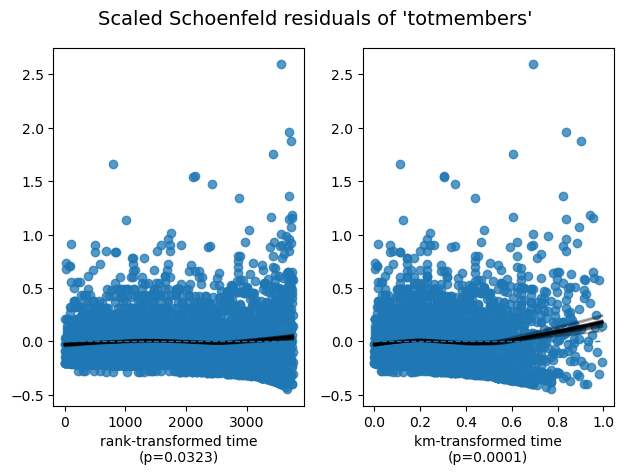

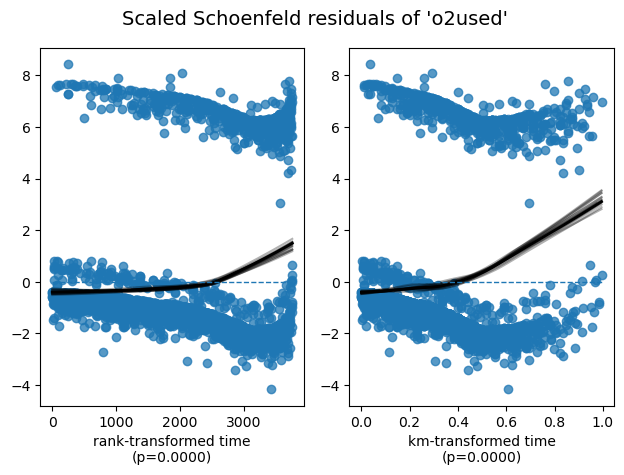

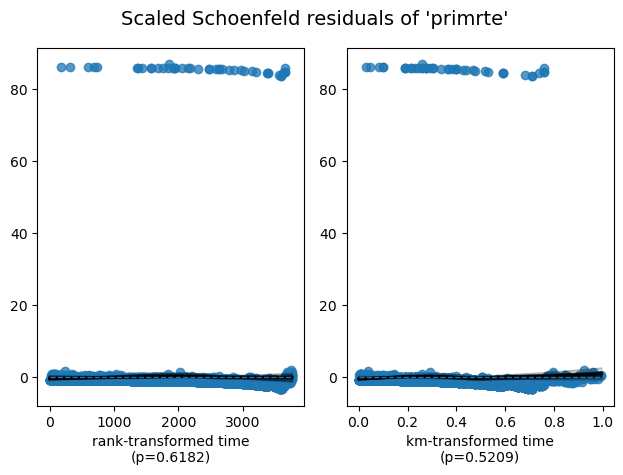

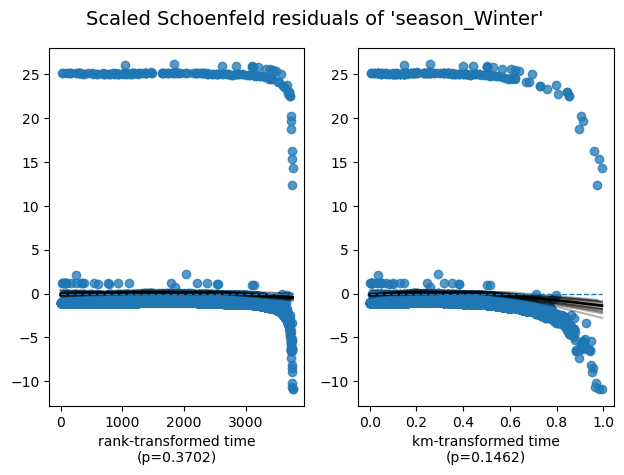

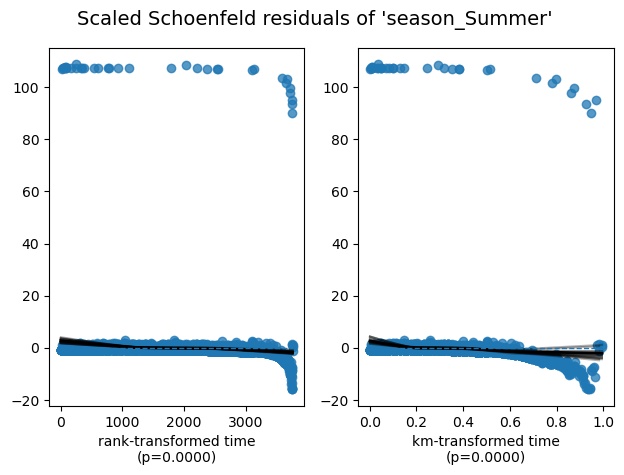

In [19]:
# Check proportional hazards assumption
cph.check_assumptions(
    cox_df,
    p_value_threshold=0.05,
    show_plots=True
)

## Interpretation of Cox Proportional Hazards Results

The Cox proportional hazards model quantifies the association between key
expedition characteristics and failure risk, conditional on expedition
duration and right-censoring.

Team size (`totmembers`) exhibits a small but statistically significant
association with expedition risk. The estimated hazard ratio below one suggests
that larger teams are associated with reduced failure risk, potentially
reflecting improved logistical redundancy and collective decision-making.
However, proportional hazards diagnostics indicate time-dependent effects for
this covariate, suggesting that its influence may vary over the course of an
expedition rather than remaining constant.

Supplemental oxygen use (`o2used`) shows a strong and statistically significant
protective effect, with a hazard ratio substantially below one. Expeditions
using oxygen experience markedly lower failure risk relative to non-oxygen
expeditions. Proportional hazards diagnostics, however, indicate clear
departures from the proportionality assumption, implying that the risk-reducing
effect of oxygen changes over time. This result is consistent with oxygen being
particularly important during specific expedition phases rather than uniformly
across the entire duration.

Route type (`primrte`) is associated with a significantly lower hazard for
primary routes compared to non-primary routes. Proportional hazards tests do not
indicate meaningful violations for this covariate, suggesting that its effect
is reasonably stable over time.

Seasonal indicators reveal mixed effects. Summer expeditions exhibit lower
baseline hazard relative to the reference season, while winter expeditions do
not show a statistically significant difference. Proportional hazards tests
flag potential violations for summer expeditions, indicating that seasonal
effects may be time-varying and interact with expedition duration.

Overall, proportional hazards diagnostics reveal that while some covariates
satisfy the proportionality assumption, others—most notably oxygen use, team
size, and summer season—exhibit time-dependent behavior. These findings do not
invalidate the Cox model but instead highlight its role as a **first-order
approximation** of expedition risk dynamics.

The presence of proportional hazards violations motivates extensions such as
stratified Cox models, time-varying covariates, or piecewise hazard
specifications, which are deferred to later modeling phases. Importantly, the
diagnostic results reinforce the earlier Kaplan–Meier and log-rank findings by
demonstrating that expedition risk is both **covariate-dependent and
nonstationary over time**.

---

## Hazard Ratio Interpretation

The Cox proportional hazards model estimates covariate effects in terms of
**hazard ratios (HRs)**, which quantify the relative change in instantaneous
failure risk associated with a one-unit change in a covariate, holding other
factors constant.

- **HR > 1** indicates an increased risk of expedition failure.
- **HR < 1** indicates a protective effect, corresponding to reduced failure
  risk.
- **HR = 1** indicates no association with hazard.

All interpretations are made at the **expedition level** and reflect relative,
not absolute, risk.

In [20]:
# Extract hazard ratios and 95% confidence intervals
hr_table = cph.summary[
    ["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
].rename(columns={
    "exp(coef)": "HR",
    "exp(coef) lower 95%": "HR_lower_95",
    "exp(coef) upper 95%": "HR_upper_95"
})

hr_table

,HR,HR_lower_95,HR_upper_95,p
covariate,,,,
totmembers,0.949153,0.941833,0.956530,7.572147e-40
o2used,0.179257,0.163671,0.196326,2.746961e-300
primrte,0.409131,0.303729,0.551112,4.102629e-09
season_Winter,0.949736,0.806730,1.118093,5.356779e-01
season_Summer,0.801956,0.575205,1.118094,1.930429e-01


## Interpretation of Hazard Ratios

Hazard ratios (HRs) quantify the relative change in instantaneous expedition
failure risk associated with each covariate, holding other factors constant.

Team size (`totmembers`) exhibits a hazard ratio slightly below one
(HR ≈ 0.95), indicating that each additional team member is associated with an
approximate **5% reduction in failure risk**. Although the per-member effect is
modest, the association is highly statistically significant, suggesting that
larger teams confer cumulative protective benefits through redundancy and shared
decision-making.

Supplemental oxygen use (`o2used`) shows a hazard ratio far below one
(HR ≈ 0.18), indicating a **substantial protective effect**. Expeditions using
supplemental oxygen experience an estimated **82% reduction in failure risk**
relative to non-oxygen expeditions. This effect is highly statistically
significant and represents one of the strongest predictors of expedition
outcome in the model.

Primary route selection (`primrte`) is associated with a hazard ratio of
approximately **0.41**, indicating that expeditions following primary routes
face roughly a **59% lower failure risk** compared to non-primary routes. This
finding is consistent with primary routes offering more established logistics,
fixed infrastructure, and risk mitigation pathways.

Seasonal indicators exhibit weaker and statistically non-significant effects.
Winter expeditions show a hazard ratio close to one (HR ≈ 0.95), suggesting no
meaningful difference in baseline risk relative to the reference season. Summer
expeditions exhibit a hazard ratio below one (HR ≈ 0.80), but the associated
confidence interval includes unity, indicating that the observed reduction in
risk is not statistically distinguishable from zero at conventional significance
levels.

Overall, the hazard ratio estimates indicate that **operational and logistical
choices**, particularly oxygen use and route selection, play a dominant role in
shaping expedition risk, while seasonal effects appear more nuanced once other
covariates are accounted for.

---

## Survival Comparison Summary Table

The table below summarizes covariate-specific effects from the Cox proportional
hazards model. Reported values include hazard ratios (HR), 95% confidence
intervals, and associated p-values.

Hazard ratios greater than one indicate increased expedition failure risk,
while values below one indicate protective effects. Confidence intervals that
exclude unity correspond to statistically significant effects at the 5% level.

In [21]:
# Create publication-ready survival comparison table

summary_table = (
    cph.summary
    .reset_index()                      # bring covariates out of index
    .rename(columns={
        "index": "Covariate",            # fallback if index unnamed
        "covariate": "Covariate",        # fallback if named
        "exp(coef)": "Hazard Ratio",
        "exp(coef) lower 95%": "CI Lower (95%)",
        "exp(coef) upper 95%": "CI Upper (95%)",
        "p": "p-value"
    })
)

# Keep only required columns (safe filtering)
summary_table = summary_table[
    ["Covariate", "Hazard Ratio", "CI Lower (95%)", "CI Upper (95%)", "p-value"]
]

# Round for presentation
summary_table = summary_table.round({
    "Hazard Ratio": 3,
    "CI Lower (95%)": 3,
    "CI Upper (95%)": 3,
    "p-value": 4
})

summary_table

,Covariate,Hazard Ratio,CI Lower (95%),CI Upper (95%),p-value
0,totmembers,0.949,0.942,0.957,0.0000
1,o2used,0.179,0.164,0.196,0.0000
2,primrte,0.409,0.304,0.551,0.0000
3,season_Winter,0.950,0.807,1.118,0.5357
4,season_Summer,0.802,0.575,1.118,0.1930


## Survival Comparison Summary Interpretation

Table X reports hazard ratios, 95% confidence intervals, and p-values from the
Cox proportional hazards model.

Team size (`totmembers`) exhibits a hazard ratio of 0.949 (95% CI: 0.942–0.957),
indicating that each additional team member is associated with an approximate
5% reduction in expedition failure risk. This effect is highly statistically
significant, suggesting a consistent protective influence of larger team size.

Supplemental oxygen use (`o2used`) shows a pronounced protective effect, with a
hazard ratio of 0.179 (95% CI: 0.164–0.196). Expeditions utilizing supplemental
oxygen experience an estimated 82% lower failure risk relative to non-oxygen
expeditions. This variable represents the strongest predictor of expedition
outcome in the model.

Primary route selection (`primrte`) is also strongly associated with reduced
risk (HR = 0.409; 95% CI: 0.304–0.551), indicating that expeditions following
primary routes face substantially lower termination risk compared to
non-primary routes.

Seasonal indicators display weaker and statistically non-significant effects.
Winter expeditions exhibit a hazard ratio of 0.950 (95% CI: 0.807–1.118), while
summer expeditions show a hazard ratio of 0.802 (95% CI: 0.575–1.118). In both
cases, confidence intervals include unity, indicating that seasonal effects are
not statistically distinguishable from zero once operational covariates are
accounted for.

Overall, the results highlight that **logistical and operational decisions**
— particularly oxygen use, route choice, and team size — dominate seasonal
factors in explaining expedition failure risk.

---

## Export of Survival Comparison Table

For reproducibility and downstream manuscript preparation, the Cox model
summary table is exported as a standalone CSV file. This table will be used
directly in the Phase 4 paper draft (Results section).

In [23]:
summary_table.to_csv(
    "../results/cox_summary_table.csv",
    index=False
)

The exported table contains covariate-specific hazard ratios, 95% confidence
intervals, and p-values in a publication-ready format. This separation of
estimation and reporting ensures transparent workflow management and facilitates
direct integration into the final manuscript.

---

## Phase 2 Conclusion — Statistical Modeling

This phase introduced formal statistical modeling to quantify expedition risk
under censoring and heterogeneous exposure durations.

Key outcomes of Phase 2 include:

- Construction of a time-to-event framework with explicit event and censoring
  definitions tailored to expedition failure and completion
- Non-parametric estimation of survival functions using Kaplan–Meier methods,
  revealing substantial heterogeneity in expedition risk over time
- Formal survival curve comparisons using log-rank tests across seasons,
  expedition nationality, and operational characteristics
- Estimation of a Cox proportional hazards model to quantify covariate-specific
  effects on expedition failure risk
- Interpretation of hazard ratios with confidence intervals, emphasizing effect
  size and uncertainty rather than statistical significance alone
- Diagnostic assessment of the proportional hazards assumption, identifying
  covariates exhibiting potential time-varying effects

The results demonstrate that operational decisions—particularly supplemental
oxygen use, route selection, and team size—play a dominant role in shaping
expedition outcomes. Seasonal effects, while evident in unadjusted survival
curves, become weaker once these operational factors are accounted for.

By explicitly evaluating model assumptions and limitations, this phase provides
a transparent and statistically principled assessment of expedition risk rather
than a purely descriptive or predictive analysis.

---

## Bridge to Phase 3 — From Hazard-Based Inference to Predictive Modeling

While survival analysis offers interpretable estimates of covariate effects
under well-defined assumptions, the diagnostics in Phase 2 indicate that some
risk factors may exhibit non-linear or time-varying behavior that is not fully
captured by proportional hazards models.

To address these limitations, Phase 3 transitions toward machine learning–based
predictive models for summit outcomes. These approaches relax parametric and
proportionality assumptions, enabling flexible modeling of complex interactions
and non-linear risk structures.

Phase 3 will build on Phase 2 by introducing:

- Logistic regression models as a baseline probabilistic classifier
- Random forest models to capture non-linear dependencies and interaction effects
- Feature importance analysis to identify dominant predictors of summit success
- Comparative evaluation of model performance across statistical and
  machine-learning frameworks

This progression allows for a complementary perspective on expedition risk,
combining inferential survival analysis with predictive performance and model
robustness.

---

## Exporting Statistical Modeling Results (Phase 2)

To support reproducibility and downstream synthesis, the key outputs from Phase 2
are exported as structured CSV files. These tables contain numerical results that
are directly referenced in the results and discussion sections, independent of
visualizations.

Specifically, this includes:

- Hazard ratio estimates from the Cox proportional hazards model, with
  corresponding 95% confidence intervals and p-values
- Formal survival comparison results from log-rank tests across key expedition
  groupings

Exporting these results ensures transparency, and allows all inferential conclusions to be audited without
re-running the full analysis.

In [26]:
# Cox PH summary table (paper-ready)
cox_summary = (
    cph.summary
    .reset_index()
    .rename(columns={
        "index": "covariate",
        "exp(coef)": "Hazard_Ratio",
        "exp(coef) lower 95%": "CI_Lower_95",
        "exp(coef) upper 95%": "CI_Upper_95",
        "p": "p_value"
    })[
        ["covariate", "Hazard_Ratio", "CI_Lower_95", "CI_Upper_95", "p_value"]
    ]
)

cox_summary.to_csv(
    "../results/phase2_cox_summary_table.csv",
    index=False
)

cox_summary

,covariate,Hazard_Ratio,CI_Lower_95,CI_Upper_95,p_value
0,totmembers,0.949153,0.941833,0.956530,7.572147e-40
1,o2used,0.179257,0.163671,0.196326,2.746961e-300
2,primrte,0.409131,0.303729,0.551112,4.102629e-09
3,season_Winter,0.949736,0.806730,1.118093,5.356779e-01
4,season_Summer,0.801956,0.575205,1.118094,1.930429e-01


### Interpretation of Cox Proportional Hazards Estimates

The Cox model reveals several statistically significant covariate effects on expedition failure risk.

Team size (`totmembers`) exhibits a modest but significant protective effect, with a hazard ratio slightly below 1, indicating lower failure risk for larger expeditions. Oxygen use (`o2used`) is associated with a substantial reduction in hazard, consistent with its role in mitigating physiological risk at high altitude. Primary routes (`primrte`) also demonstrate a protective effect relative to non-primary routes.

Seasonal indicators show no statistically significant deviation from the spring baseline once other covariates are controlled for, suggesting that much of the seasonal risk variation is mediated through expedition characteristics rather than season alone.

In [27]:
from lifelines.statistics import logrank_test

logrank_results = pd.DataFrame([
    {
        "Comparison": "Spring vs Autumn",
        "Test_Statistic": lr_spring_autumn.test_statistic,
        "p_value": lr_spring_autumn.p_value
    },
    {
        "Comparison": "Domestic vs Foreign",
        "Test_Statistic": lr_domestic_foreign.test_statistic,
        "p_value": lr_domestic_foreign.p_value
    },
    {
        "Comparison": "Oxygen vs No Oxygen",
        "Test_Statistic": lr_oxygen.test_statistic,
        "p_value": lr_oxygen.p_value
    }
])

logrank_results.to_csv(
    "../results/phase2_logrank_test_results.csv",
    index=False
)

logrank_results

,Comparison,Test_Statistic,p_value
0,Spring vs Autumn,681.347643,3.402983e-150
1,Domestic vs Foreign,20.988168,4.621287e-06
2,Oxygen vs No Oxygen,1888.338417,0.000000e+00


### Log-Rank Survival Comparisons

Log-rank tests indicate statistically significant differences in survival distributions across all examined groupings.

Seasonal timing exhibits a pronounced effect on expedition survival duration (Spring vs Autumn), suggesting systematically different risk profiles across climbing windows. Expedition nationality (Domestic vs Foreign) also shows a significant separation, consistent with heterogeneous logistical, experiential, or environmental exposures. The strongest divergence is observed between oxygen-assisted and non-oxygen expeditions, highlighting supplemental oxygen as a dominant determinant of time-to-failure dynamics.

These results provide formal statistical support for stratified survival patterns and motivate covariate inclusion in subsequent hazard-based and predictive models.

---

**Status:** Phase 2 completed — expedition outcomes modeled using Kaplan–Meier
estimators, log-rank tests, and Cox proportional hazards models with diagnostic
validation; results motivate flexible predictive modeling and comparison in
Phase 3.